In [1]:
#-----------------------------------------------------------------------------------------------
# Construction cost predictive modeling
# by D. Chakraborty on 9/20/2020
#-----------------------------------------------------------------------------------------------
import random
import pandas as pd
import time
import datetime
import os
import numpy as np
from calendar import isleap
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 
import matplotlib.dates as mdates
from datetime import datetime, timedelta
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from ngboost.api import NGBRegressor
from ngboost.distns import Normal
from ngboost.scores import MLE
from ngboost.evaluation import *
from scipy import stats
from scipy.stats import norm, skew
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.feature_selection import RFECV
from sklearn.metrics import mean_squared_error, r2_score, make_scorer
from sklearn.preprocessing import MinMaxScaler
from time import time
from pprint import pprint
import shap
shap.initjs()
import os

In [2]:
def read_tabular_data(file_name,base_dir):
    df      = os.path.join(base_dir,file_name)
    df_read = pd.read_excel(df, thousands=r',')                                   
    return df_read

In [3]:
base_dir = r"C:\Users\wlv446\Documents\AI_Construction_Estimation_Journal_Publication\Data_Files"
###################################################################################################
filename = r"Mixed_Dataset_V7.xlsx"
Data_DF = read_tabular_data(filename, base_dir)

Data_DF= Data_DF[Data_DF['Total Cost [\$/$ft^2$]'] != 0] # Eliminating missing data from the dataframe
Data_DF.dropna(inplace=True)
Data_DF.to_excel("Mixed_Dataset_No_Zero.xlsx")

Data_DF.head()

Type  Tributary Area [$ft^2$]  Superimposed Load [lbs./$ft^2$]  \
0     1                      225                               40   
1     1                      225                               75   
2     1                      225                              125   
3     1                      225                              200   
4     1                      300                               40   

   Formwork [\$/$ft^2$]  Concrete [\$/$ft^3$]  Total Cost [\$/$ft^2$]  
0              4.384787              2.105263                    9.87  
1              4.384787              2.105263                    9.96  
2              4.384787              2.105263                   10.07  
3              4.384787              2.105263                   10.49  
4              4.384787              2.105263                    9.82

In [4]:
Data_DF.describe()

Type  Tributary Area [$ft^2$]  Superimposed Load [lbs./$ft^2$]  \
count  4477.000000              4477.000000                      4477.000000   
mean      3.589681               763.122627                       107.044896   
std       1.781348               421.868634                        58.797915   
min       1.000000               225.000000                        40.000000   
25%       2.000000               400.000000                        40.000000   
50%       4.000000               625.000000                        75.000000   
75%       5.000000              1050.000000                       125.000000   
max       6.000000              1800.000000                       200.000000   

       Formwork [\$/$ft^2$]  Concrete [\$/$ft^3$]  Total Cost [\$/$ft^2$]  
count           4477.000000           4477.000000             4477.000000  
mean               7.427951              3.545461               16.810920  
std                2.275921              0.957371                4.322783  
min                4.194631              1.730000                7.700000  
25%                5.877016              2.720721               13.380000  
50%                6.790000              3.821510               16.700000  
75%                8.729282              4.217391               20.000000  
max               13.750000              5.225225               29.750000

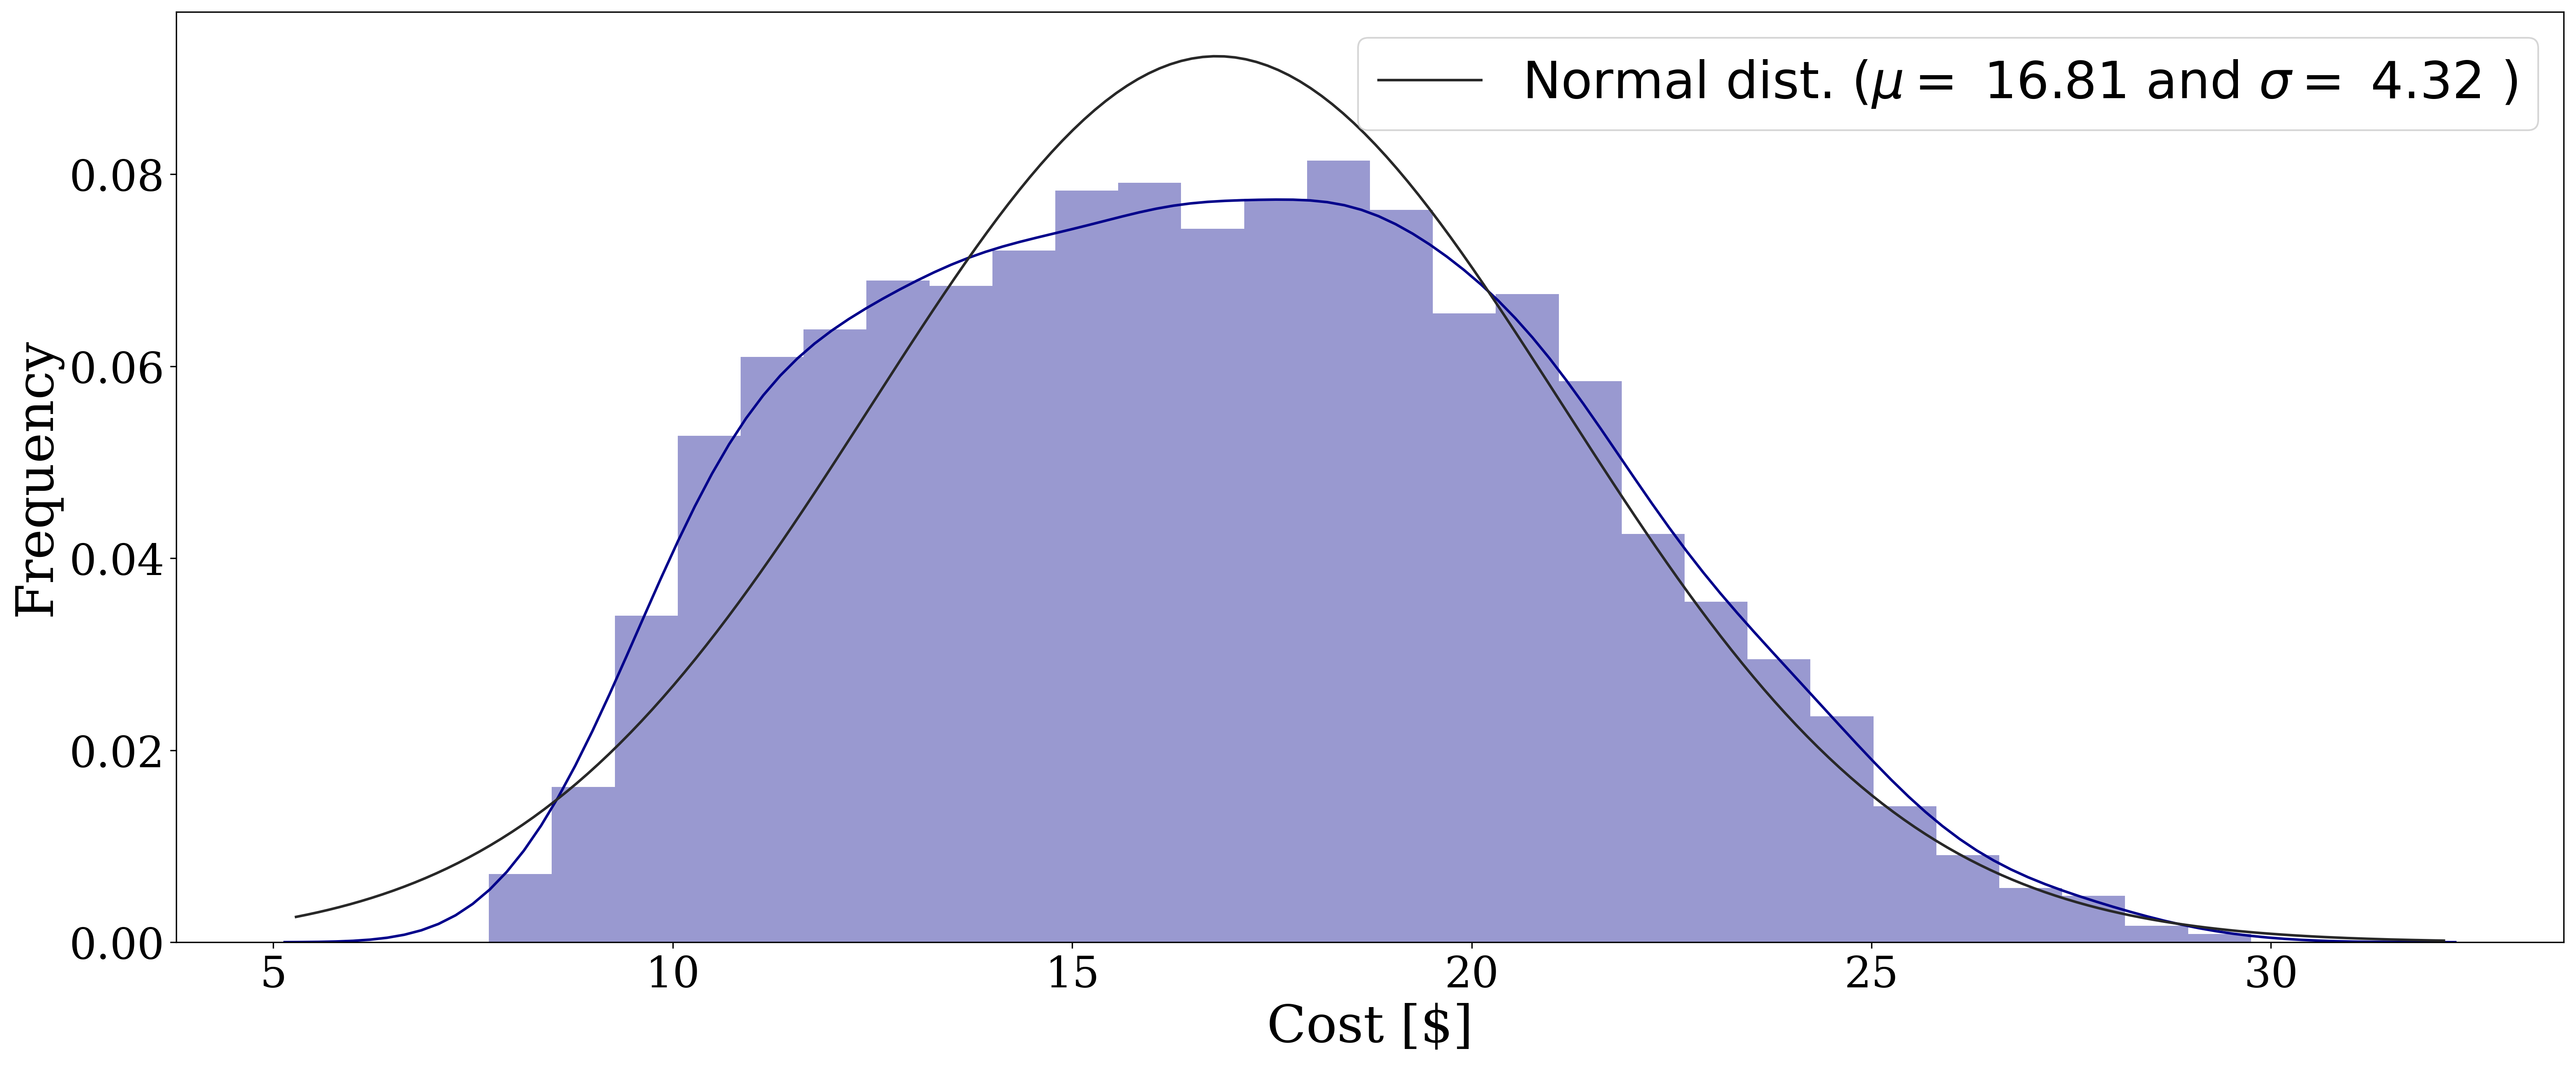

In [5]:
fig = plt.figure(figsize=(25,10),dpi=300)
sns.distplot(Data_DF['Total Cost [\$/$ft^2$]'], fit = norm, color='darkblue')
(mu, sigma) = norm.fit(Data_DF['Total Cost [\$/$ft^2$]'])
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best', fontsize=30)
plt.xlabel('Cost [$]', fontsize=30, fontname='Serif')
plt.ylabel('Frequency', fontsize=30, fontname='Serif')
plt.xticks(fontsize=25, fontname='Serif')
plt.yticks(fontsize=25, fontname='Serif')
plt.figaspect(1.)
plt.title('')
plt.savefig('Assembly Cost Distribution.pdf')

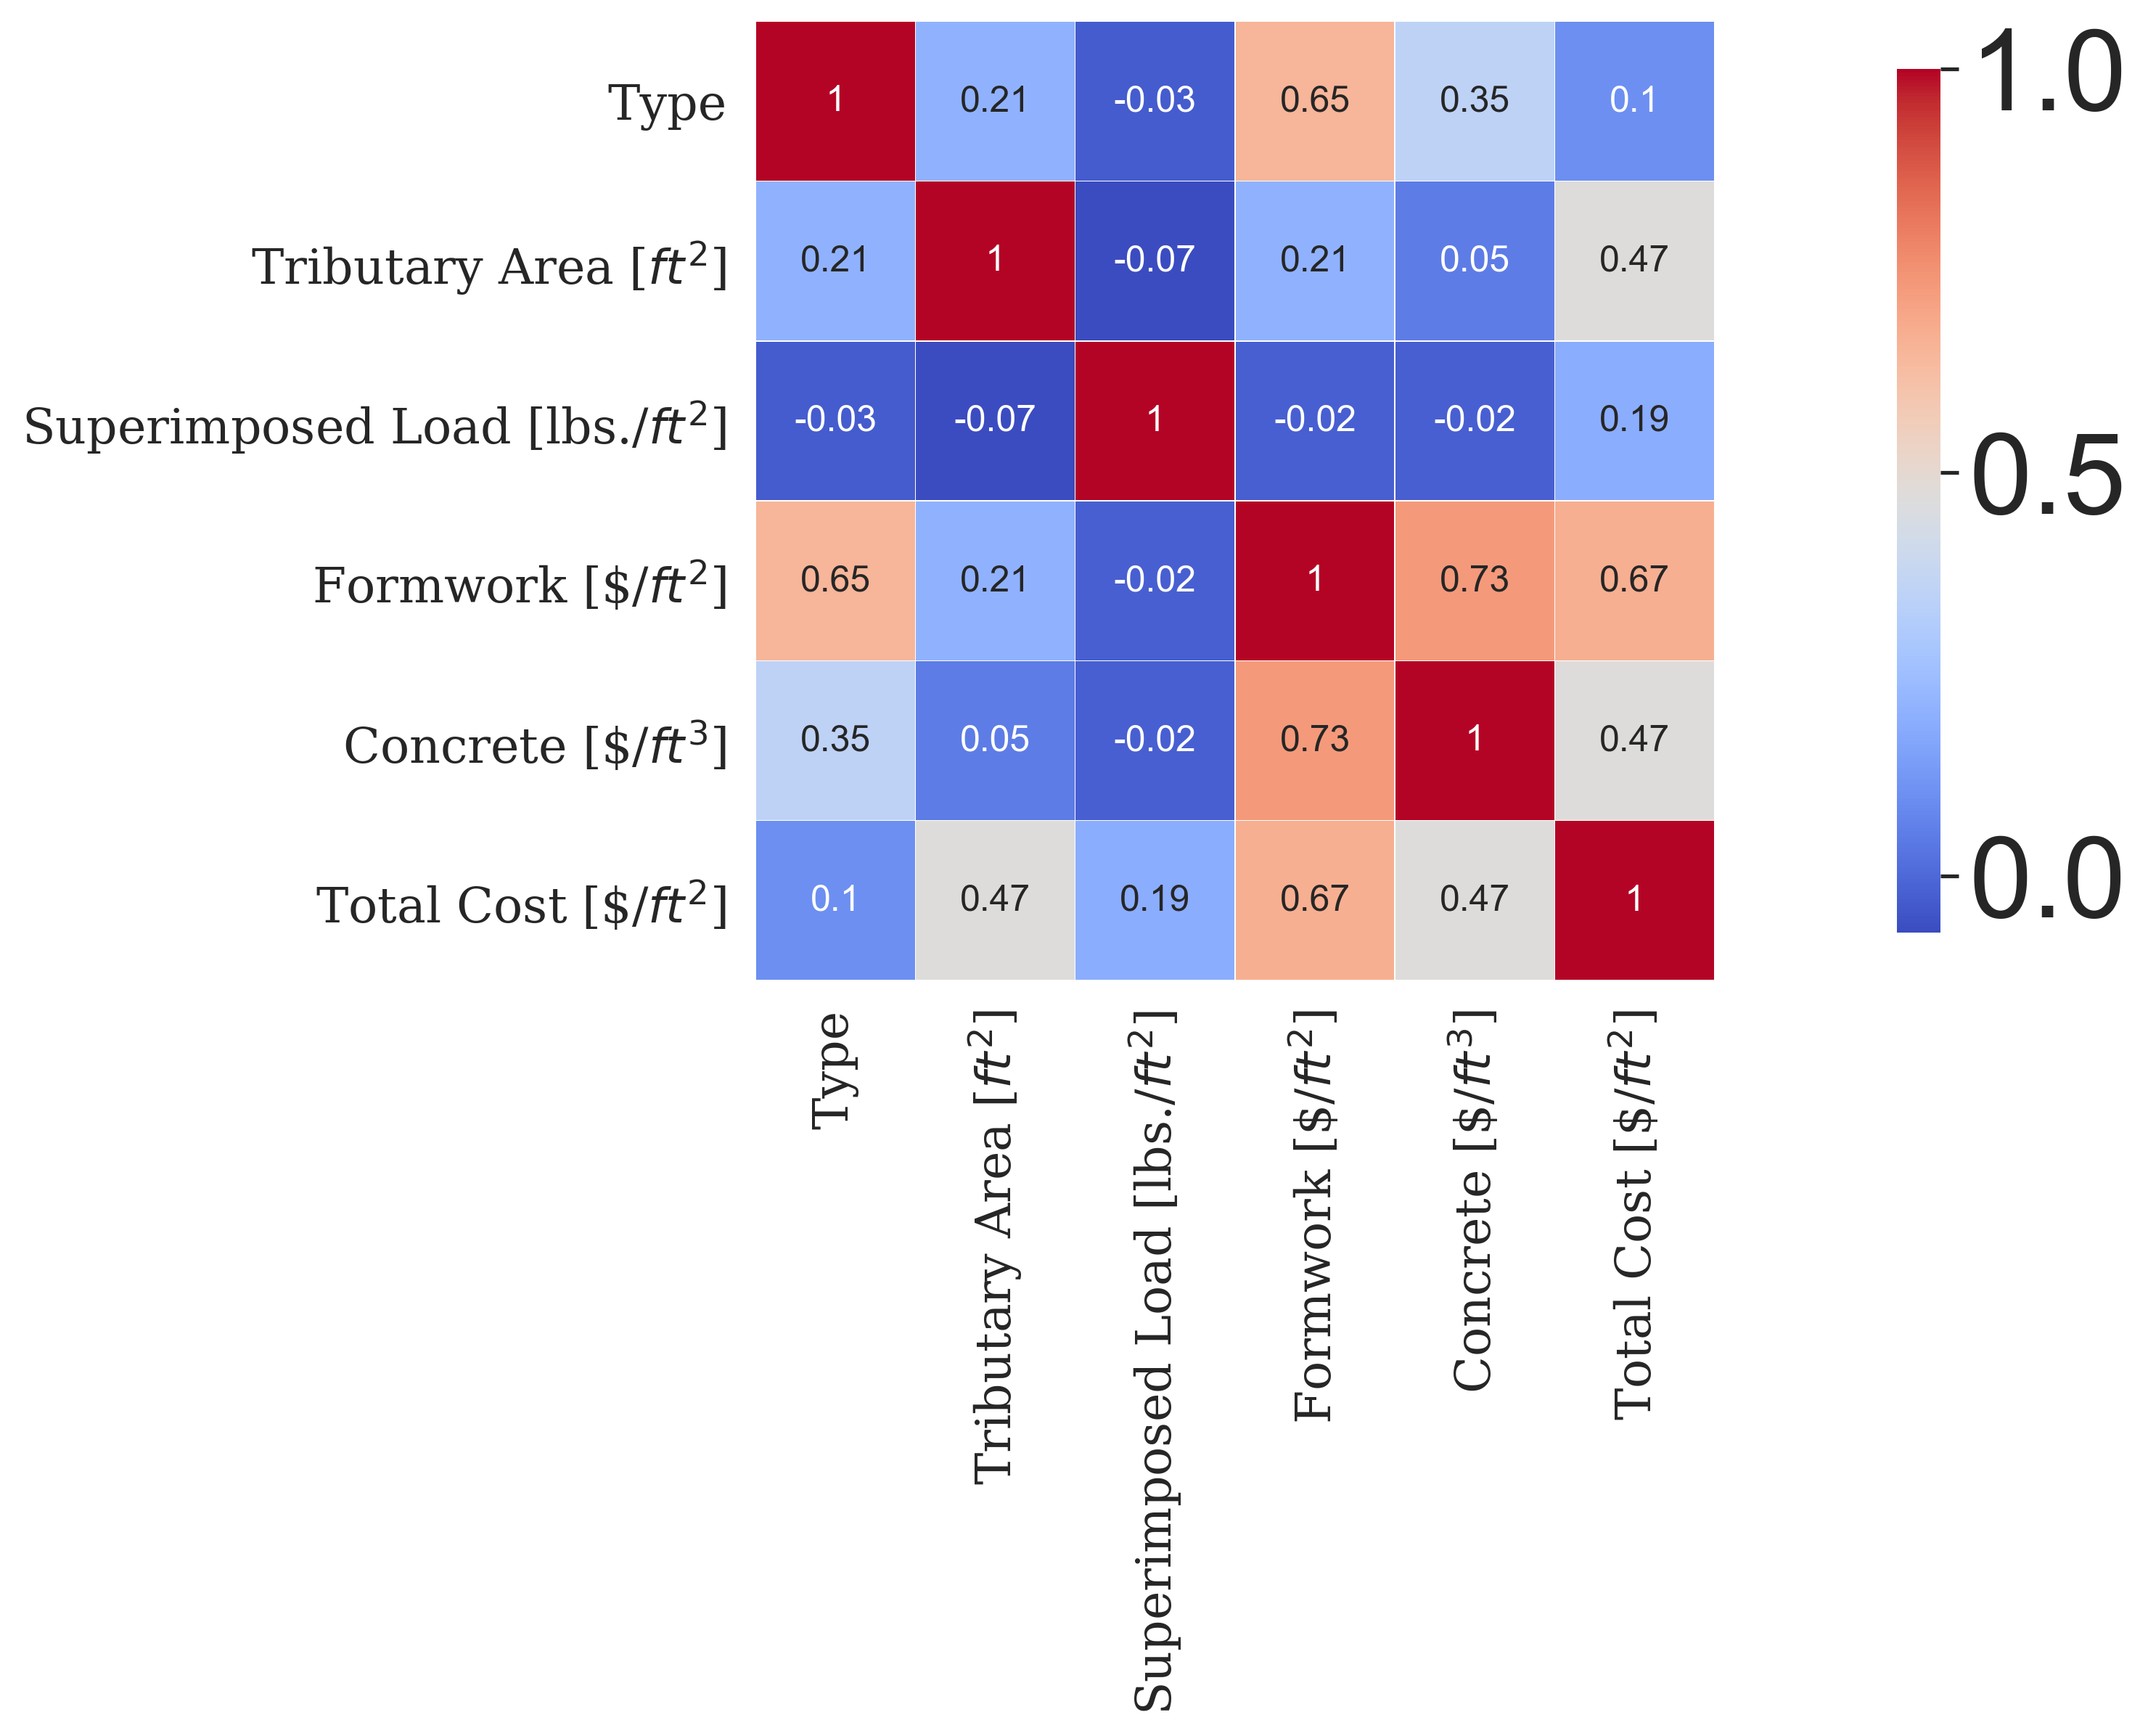

In [6]:
single_variate_corr_1 = Data_DF.corr('pearson')
fig = plt.figure(figsize=(18,9),dpi=300)
sns.set(font_scale=3.4)
sns.heatmap(np.round(single_variate_corr_1,2), vmax=1, square=True, linewidths=.1, annot=True, annot_kws={"size": 12}, 
            cbar_kws={"shrink": .9}, cmap='coolwarm')
plt.xticks(fontsize=16, fontname='Serif', rotation=90)
plt.yticks(fontsize=16, fontname='Serif')
plt.figaspect(1.)
plt.title('')
plt.tight_layout(pad=1.08)
fig.savefig('Correlation Heatmap.pdf', format='pdf', dpi=300, bbox_inches = 'tight')

In [7]:
Feature_Names = ['Type', 'Tributary Area [$ft^2$]', 'Superimposed Load [lbs./$ft^2$]', 'Formwork [\$/$ft^2$]', 
                 'Concrete [\$/$ft^3$]']

X = Data_DF[Feature_Names].to_numpy()
y = Data_DF['Total Cost [\$/$ft^2$]'].to_numpy()
#################################################################################################
# To test the model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=7)
#################################################################################################
# Feature scaling required for neural network
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(X_train)
scaled_X_train = scaler.transform(X_train)
scaled_X_test = scaler.transform(X_test)

scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(y_train.reshape(-1, 1))
scaled_y_train = scaler.transform(y_train.reshape(-1, 1))
scaled_y_test = scaler.transform(y_test.reshape(-1, 1))
#################################################################################################
np.random.seed(7)
scoring_param = make_scorer(mean_squared_error,greater_is_better=False)
#################################################################################################

# Neural Network

In [8]:
n_features = scaled_X_train.shape[1]
model = Sequential()
model.add(Dense(10, activation='relu', kernel_initializer='he_normal', input_shape=(n_features,)))
model.add(Dense(8, activation='relu', kernel_initializer='he_normal'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='mse')

t0 = time()

history = model.fit(scaled_X_train, scaled_y_train, epochs=150, batch_size=32, verbose=0, use_multiprocessing=True)

t1 = time()
Time_Taken = (t1-t0)/60
print("Time taken to train the model: %0.2f" % Time_Taken,"minutes")

#----------------------------------------------------------------------------------------------------------
#  min, max values of Cost in the training data
#----------------------------------------------------------------------------------------------------------
ymin = min(y_train)
ymax = max(y_train)

multiplier = ymax - ymin
#----------------------------------------------------------------------------------------------------------
# evaluate the model on training data
#----------------------------------------------------------------------------------------------------------
Y_hat = model.predict(scaled_X_train)

Y_Train_Pred = (ymin + Y_hat * multiplier)

rmse = np.sqrt(mean_squared_error(y_train,Y_Train_Pred))
RSQ = r2_score(y_train,Y_Train_Pred)
MBE = np.mean(y_train - Y_Train_Pred)
################################################################
################################################################
print("############ Model Accuracy on Daily Testing Data ############")
print("RMSE: %0.3f" % rmse)
print("R-squared: %0.3f" % RSQ)
print("MBE: %0.3f" % MBE)
print("########################################")
print(" ")
#----------------------------------------------------------------------------------------------------------
# evaluate the model on testing data
#----------------------------------------------------------------------------------------------------------
Y_hat = model.predict(scaled_X_test)

Y_Test_Pred = (ymin + Y_hat * multiplier)

rmse = np.sqrt(mean_squared_error(y_test,Y_Test_Pred))
RSQ = r2_score(y_test,Y_Test_Pred)
MBE = np.mean(y_test - Y_Test_Pred)
################################################################
################################################################
print("############ Model Accuracy on Daily Testing Data ############")
print("RMSE: %0.3f" % rmse)
print("R-squared: %0.3f" % RSQ)
print("MBE: %0.3f" % MBE)
print("########################################")
print(" ")

Time taken to train the model: 0.23 minutes
############ Model Accuracy on Daily Testing Data ############
RMSE: 0.813
R-squared: 0.965
MBE: -0.124
########################################
 
############ Model Accuracy on Daily Testing Data ############
RMSE: 0.893
R-squared: 0.957
MBE: -0.103
########################################
 


# Linear Regression

In [9]:
t0 = time()

lin_reg = LinearRegression(normalize=True).fit(X_train, y_train)

t1 = time()
Time_Taken = (t1-t0)
print("Time taken to train the model: %0.2f" % Time_Taken,"seconds")

Y_Train_Pred = lin_reg.predict(X_train)

rmse = np.sqrt(mean_squared_error(y_train.ravel(),Y_Train_Pred))
RSQ = r2_score(y_train.ravel(),Y_Train_Pred)
MBE = np.mean(y_train.ravel() - Y_Train_Pred)
################################################################
################################################################
print("############ Model Accuracy on Daily Training Data ############")
print("RMSE: %0.3f" % rmse)
print("R-squared: %0.3f" % RSQ)
print("MBE: %0.3f" % MBE)
print("########################################")
print(" ")

Y_Test_Pred = lin_reg.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test.ravel(),Y_Test_Pred))
RSQ = r2_score(y_test.ravel(),Y_Test_Pred)
MBE = np.mean(y_test.ravel() - Y_Test_Pred)
################################################################
################################################################
print("############ Model Accuracy on Daily Testing Data ############")
print("RMSE: %0.3f" % rmse)
print("R-squared: %0.3f" % RSQ)
print("MBE: %0.3f" % MBE)
print("########################################")
print(" ")
################################################################
################################################################
print("############ Model Coefficients ############")
print(np.round((lin_reg.coef_),2))

Time taken to train the model: 0.01 seconds
############ Model Accuracy on Daily Training Data ############
RMSE: 1.750
R-squared: 0.836
MBE: 0.000
########################################
 
############ Model Accuracy on Daily Testing Data ############
RMSE: 1.792
R-squared: 0.827
MBE: 0.102
########################################
 
############ Model Coefficients ############
[-1.53  0.    0.02  2.02 -0.42]


# Random Forest

In [10]:
t0 = time()

p_grid = dict(n_estimators = [int(i) for i in np.linspace(100,2000,num=20)],
    max_depth = [int(i) for i in np.linspace(1,10,num=10)],
  min_samples_leaf = [int(i) for i in np.linspace(1,10,num=10)])

rf = GridSearchCV(estimator = RandomForestRegressor(random_state=7), param_grid = p_grid, 
                     scoring = scoring_param, cv = 3, verbose=1, n_jobs=-1)

rf.fit(X_train, y_train.ravel())

t1 = time()
Time_Taken = (t1-t0)
print("Time taken to train the model: %0.2f" % Time_Taken,"seconds")
print("Best RF Estimators: %0.3f" % rf.best_params_.get('n_estimators'))
print("Best RF Max Depth: %0.3f" % rf.best_params_.get('max_depth'))
print("Best RF Min Samples in Leaf: %0.3f" % rf.best_params_.get('min_samples_leaf'))

Y_Train_Pred = rf.predict(X_train)

rmse = np.sqrt(mean_squared_error(y_train.ravel(),Y_Train_Pred))
RSQ = r2_score(y_train.ravel(),Y_Train_Pred)
MBE = np.mean(y_train.ravel() - Y_Train_Pred)
################################################################
################################################################
print("############ Model Accuracy on Daily Training Data ############")
print("RMSE: %0.3f" % rmse)
print("R-squared: %0.3f" % RSQ)
print("MBE: %0.3f" % MBE)
print("########################################")
print(" ")

Y_Test_Pred = rf.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test.ravel(),Y_Test_Pred))
RSQ = r2_score(y_test.ravel(),Y_Test_Pred)
MBE = np.mean(y_test.ravel() - Y_Test_Pred)
################################################################
################################################################
print("############ Model Accuracy on Daily Testing Data ############")
print("RMSE: %0.3f" % rmse)
print("R-squared: %0.3f" % RSQ)
print("MBE: %0.3f" % MBE)
print("########################################")
print(" ")

Fitting 3 folds for each of 2000 candidates, totalling 6000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 36 concurrent workers.
[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done 378 tasks      | elapsed:   21.2s
[Parallel(n_jobs=-1)]: Done 728 tasks      | elapsed:   40.4s
[Parallel(n_jobs=-1)]: Done 1178 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 1728 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 2378 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 3128 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 3978 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done 4928 tasks      | elapsed:  6.5min
[Parallel(n_jobs=-1)]: Done 6000 out of 6000 | elapsed:  8.4min finished


Time taken to train the model: 509.60 seconds
Best RF Estimators: 1800.000
Best RF Max Depth: 10.000
Best RF Min Samples in Leaf: 1.000
############ Model Accuracy on Daily Training Data ############
RMSE: 0.398
R-squared: 0.992
MBE: 0.003
########################################
 
############ Model Accuracy on Daily Testing Data ############
RMSE: 0.675
R-squared: 0.975
MBE: 0.001
########################################
 


# XGBoost

In [11]:
t0 = time()

p_grid = dict(n_estimators = [int(i) for i in np.linspace(100,2000,num=20)],
    max_depth = [int(i) for i in np.linspace(1,10,num=10)],
  learning_rate = np.linspace(0.001,0.1,num=10))

xgb = GridSearchCV(estimator = XGBRegressor(random_state=7), param_grid = p_grid, 
                     scoring = scoring_param, cv = 3, verbose=1, n_jobs=-1)

xgb.fit(X_train, y_train.ravel())

t1 = time()
Time_Taken = (t1-t0)
print("Time taken to train the model: %0.2f" % Time_Taken,"seconds")
print("Best XGB Estimators: %0.3f" % xgb.best_params_.get('n_estimators'))
print("Best XGB Max Depth: %0.3f" % xgb.best_params_.get('max_depth'))
print("Best XGB Learning Rate: %0.3f" % xgb.best_params_.get('learning_rate'))

Y_Train_Pred = xgb.predict(X_train)

rmse = np.sqrt(mean_squared_error(y_train.ravel(),Y_Train_Pred))
RSQ = r2_score(y_train.ravel(),Y_Train_Pred)
MBE = np.mean(y_train.ravel() - Y_Train_Pred)
################################################################
################################################################
print("############ Model Accuracy on Daily Training Data ############")
print("RMSE: %0.3f" % rmse)
print("R-squared: %0.3f" % RSQ)
print("MBE: %0.3f" % MBE)
print("########################################")
print(" ")

Y_Test_Pred = xgb.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test.ravel(),Y_Test_Pred))
RSQ = r2_score(y_test.ravel(),Y_Test_Pred)
MBE = np.mean(y_test.ravel() - Y_Test_Pred)
################################################################
################################################################
print("############ Model Accuracy on Daily Testing Data ############")
print("RMSE: %0.3f" % rmse)
print("R-squared: %0.3f" % RSQ)
print("MBE: %0.3f" % MBE)
print("########################################")
print(" ")

Fitting 3 folds for each of 2000 candidates, totalling 6000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 36 concurrent workers.
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done 378 tasks      | elapsed:   27.1s
[Parallel(n_jobs=-1)]: Done 728 tasks      | elapsed:   42.9s
[Parallel(n_jobs=-1)]: Done 1178 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 1728 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 2378 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 3128 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 3978 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 4928 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 6000 out of 6000 | elapsed:  4.5min finished


Time taken to train the model: 273.76 seconds
Best XGB Estimators: 1200.000
Best XGB Max Depth: 3.000
Best XGB Learning Rate: 0.045
############ Model Accuracy on Daily Training Data ############
RMSE: 0.359
R-squared: 0.993
MBE: 0.000
########################################
 
############ Model Accuracy on Daily Testing Data ############
RMSE: 0.495
R-squared: 0.987
MBE: -0.006
########################################
 


# Light GBM

In [12]:
t0 = time()

p_grid = dict(n_estimators = [int(i) for i in np.linspace(100,2000,num=20)],
    max_depth = [int(i) for i in np.linspace(1,10,num=10)],
  learning_rate = np.linspace(0.001,0.1,num=10))

lgb = GridSearchCV(estimator = LGBMRegressor(random_state=7), param_grid = p_grid, 
                     scoring = scoring_param, cv = 3, verbose=1, n_jobs=-1)

lgb.fit(X_train, y_train.ravel())

t1 = time()
Time_Taken = (t1-t0)
print("Time taken to train the model: %0.2f" % Time_Taken,"seconds")
print("Best LGB Estimators: %0.3f" % lgb.best_params_.get('n_estimators'))
print("Best LGB Max Depth: %0.3f" % lgb.best_params_.get('max_depth'))
print("Best LGB Learning Rate: %0.3f" % lgb.best_params_.get('learning_rate'))

Y_Train_Pred = lgb.predict(X_train)

rmse = np.sqrt(mean_squared_error(y_train.ravel(),Y_Train_Pred))
RSQ = r2_score(y_train.ravel(),Y_Train_Pred)
MBE = np.mean(y_train.ravel() - Y_Train_Pred)
################################################################
################################################################
print("############ Model Accuracy on Daily Training Data ############")
print("RMSE: %0.3f" % rmse)
print("R-squared: %0.3f" % RSQ)
print("MBE: %0.3f" % MBE)
print("########################################")
print(" ")

Y_Test_Pred = lgb.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test.ravel(),Y_Test_Pred))
RSQ = r2_score(y_test.ravel(),Y_Test_Pred)
MBE = np.mean(y_test.ravel() - Y_Test_Pred)
################################################################
################################################################
print("############ Model Accuracy on Daily Testing Data ############")
print("RMSE: %0.3f" % rmse)
print("R-squared: %0.3f" % RSQ)
print("MBE: %0.3f" % MBE)
print("########################################")
print(" ")

Fitting 3 folds for each of 2000 candidates, totalling 6000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 36 concurrent workers.
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 558 tasks      | elapsed:   12.4s
[Parallel(n_jobs=-1)]: Done 908 tasks      | elapsed:   17.5s
[Parallel(n_jobs=-1)]: Done 1358 tasks      | elapsed:   27.2s
[Parallel(n_jobs=-1)]: Done 1908 tasks      | elapsed:   38.7s
[Parallel(n_jobs=-1)]: Done 2558 tasks      | elapsed:   51.0s
[Parallel(n_jobs=-1)]: Done 3308 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 4158 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 5108 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 6000 out of 6000 | elapsed:  2.0min finished


Time taken to train the model: 119.52 seconds
Best LGB Estimators: 1800.000
Best LGB Max Depth: 4.000
Best LGB Learning Rate: 0.034
############ Model Accuracy on Daily Training Data ############
RMSE: 0.310
R-squared: 0.995
MBE: 0.000
########################################
 
############ Model Accuracy on Daily Testing Data ############
RMSE: 0.488
R-squared: 0.987
MBE: -0.009
########################################
 


# Natural GBM

In [13]:
t0 = time()

p_grid = dict(n_estimators = [int(i) for i in np.linspace(100,2000,num=20)],
              minibatch_frac = np.linspace(0.1,1,num=10),
              learning_rate = np.linspace(0.01,0.1,num=10))

ngb = GridSearchCV(estimator = NGBRegressor(random_state=7), param_grid = p_grid, 
                     scoring = scoring_param, cv = 3, verbose=1, n_jobs=-1)

ngb.fit(X_train, y_train.ravel())

t1 = time()
Time_Taken = (t1-t0)
print("Time taken to train the model: %0.2f" % Time_Taken,"seconds")
print("Best NGB Estimators: %0.3f" % ngb.best_params_.get('n_estimators'))
print("Best NGB Minibatch Fraction: %0.3f" % ngb.best_params_.get('minibatch_frac'))
print("Best NGB Learning Rate: %0.3f" % ngb.best_params_.get('learning_rate'))

ngb = NGBRegressor(n_estimators = ngb.best_params_.get('n_estimators'), minibatch_frac = ngb.best_params_.get('minibatch_frac'),
                   learning_rate = ngb.best_params_.get('learning_rate'), random_state=7)

ngb.fit(X_train, y_train.ravel())

Y_Train_Pred = ngb.pred_dist(X_train)

rmse = np.sqrt(mean_squared_error(y_train.ravel(), Y_Train_Pred.dist.mean()))
RSQ = r2_score(y_train.ravel(), Y_Train_Pred.dist.mean())
MBE = np.mean(y_train.ravel() - Y_Train_Pred.loc)
################################################################
UB = (Y_Train_Pred.loc + 1.96 * Y_Train_Pred.scale)
LB = (Y_Train_Pred.loc - 1.96 * Y_Train_Pred.scale)
count = 0
n = len(y_train)
for i in range(n):
    if (y_train[i] <= UB[i] and y_train[i] >= LB[i]):
#         print(i)
        count = count + 1

Acc = 100*count/n
################################################################
print("############ Model Accuracy ############")
print("RMSE: %0.3f" % rmse)
print("R-squared: %0.3f" % RSQ)
print("MBE: %0.3f" % MBE)
print("# of points inside PI: %0.1f" % Acc,"%")
print("########################################")
print(" ")

Y_Test_Pred = ngb.pred_dist(X_test)

rmse = np.sqrt(mean_squared_error(y_test.ravel(),Y_Test_Pred.loc))
RSQ = r2_score(y_test.ravel(),Y_Test_Pred.loc)
MBE = np.mean(y_test.ravel() - Y_Test_Pred.loc)
################################################################
UB = (Y_Test_Pred.loc + 1.96 * Y_Test_Pred.scale)
LB = (Y_Test_Pred.loc - 1.96 * Y_Test_Pred.scale)
count = 0
n = len(y_test)
for i in range(n):
    if (y_test[i] <= UB[i] and y_test[i] >= LB[i]):
#         print(i)
        count = count + 1

Acc = 100*count/n
################################################################
print("############ Model Accuracy on Testing Data ############")
print("RMSE: %0.3f" % rmse)
print("R-squared: %0.3f" % RSQ)
print("MBE: %0.3f" % MBE)
print("# of points inside PI: %0.1f" % Acc,"%")
print("########################################")
print(" ")

Fitting 3 folds for each of 2000 candidates, totalling 6000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 36 concurrent workers.
[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:   36.0s
[Parallel(n_jobs=-1)]: Done 378 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 728 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 1178 tasks      | elapsed:  6.4min
[Parallel(n_jobs=-1)]: Done 1728 tasks      | elapsed:  9.3min
[Parallel(n_jobs=-1)]: Done 2378 tasks      | elapsed: 12.8min
[Parallel(n_jobs=-1)]: Done 3128 tasks      | elapsed: 16.8min
[Parallel(n_jobs=-1)]: Done 3978 tasks      | elapsed: 21.4min
[Parallel(n_jobs=-1)]: Done 4928 tasks      | elapsed: 26.6min
[Parallel(n_jobs=-1)]: Done 6000 out of 6000 | elapsed: 32.8min finished


[iter 0] loss=2.8868 val_loss=0.0000 scale=1.0000 norm=3.6870
[iter 100] loss=1.0291 val_loss=0.0000 scale=1.0000 norm=0.7842
[iter 200] loss=0.5926 val_loss=0.0000 scale=1.0000 norm=0.6405
[iter 300] loss=0.3901 val_loss=0.0000 scale=1.0000 norm=0.5982
[iter 400] loss=0.2656 val_loss=0.0000 scale=1.0000 norm=0.5821
[iter 500] loss=0.1595 val_loss=0.0000 scale=1.0000 norm=0.5571
[iter 600] loss=0.0986 val_loss=0.0000 scale=0.5000 norm=0.2773
[iter 700] loss=0.0450 val_loss=0.0000 scale=1.0000 norm=0.5408
[iter 800] loss=0.0013 val_loss=0.0000 scale=0.5000 norm=0.2675
[iter 900] loss=-0.0230 val_loss=0.0000 scale=1.0000 norm=0.5343
[iter 1000] loss=-0.0510 val_loss=0.0000 scale=0.5000 norm=0.2644
[iter 1100] loss=-0.0755 val_loss=0.0000 scale=1.0000 norm=0.5275
[iter 1200] loss=-0.1004 val_loss=0.0000 scale=1.0000 norm=0.5234
[iter 1300] loss=-0.1238 val_loss=0.0000 scale=0.5000 norm=0.2574
[iter 1400] loss=-0.1404 val_loss=0.0000 scale=0.2500 norm=0.1283
[iter 1500] loss=-0.1586 val_lo

In [14]:
t0 = time()

ngb_default = NGBRegressor(random_state=7)

ngb_default.fit(X_train, y_train.ravel())

t1 = time()
Time_Taken = (t1-t0)
print("Time taken to train the model: %0.2f" % Time_Taken,"seconds")

Y_Train_Pred = ngb_default.pred_dist(X_train)

rmse = np.sqrt(mean_squared_error(y_train.ravel(), Y_Train_Pred.dist.mean()))
RSQ = r2_score(y_train.ravel(), Y_Train_Pred.dist.mean())
MBE = np.mean(y_train.ravel() - Y_Train_Pred.loc)
################################################################
UB = (Y_Train_Pred.loc + 1.96 * Y_Train_Pred.scale)
LB = (Y_Train_Pred.loc - 1.96 * Y_Train_Pred.scale)
count = 0
n = len(y_train)
for i in range(n):
    if (y_train[i] <= UB[i] and y_train[i] >= LB[i]):
#         print(i)
        count = count + 1

Acc = 100*count/n
################################################################
print("############ Model Accuracy ############")
print("RMSE: %0.3f" % rmse)
print("R-squared: %0.3f" % RSQ)
print("MBE: %0.3f" % MBE)
print("# of points inside PI: %0.1f" % Acc,"%")
print("########################################")
print(" ")

Y_Test_Pred = ngb_default.pred_dist(X_test)

rmse = np.sqrt(mean_squared_error(y_test.ravel(),Y_Test_Pred.loc))
RSQ = r2_score(y_test.ravel(),Y_Test_Pred.loc)
MBE = np.mean(y_test.ravel() - Y_Test_Pred.loc)
################################################################
UB = (Y_Test_Pred.loc + 1.96 * Y_Test_Pred.scale)
LB = (Y_Test_Pred.loc - 1.96 * Y_Test_Pred.scale)
count = 0
n = len(y_test)
for i in range(n):
    if (y_test[i] <= UB[i] and y_test[i] >= LB[i]):
#         print(i)
        count = count + 1

Acc = 100*count/n
################################################################
print("############ Model Accuracy on Testing Data ############")
print("RMSE: %0.3f" % rmse)
print("R-squared: %0.3f" % RSQ)
print("MBE: %0.3f" % MBE)
print("# of points inside PI: %0.1f" % Acc,"%")
print("########################################")
print(" ")

[iter 0] loss=2.8840 val_loss=0.0000 scale=1.0000 norm=3.6656
[iter 100] loss=2.4100 val_loss=0.0000 scale=1.0000 norm=2.1586
[iter 200] loss=1.8610 val_loss=0.0000 scale=2.0000 norm=2.4910
[iter 300] loss=1.4650 val_loss=0.0000 scale=1.0000 norm=0.9532
[iter 400] loss=1.2171 val_loss=0.0000 scale=1.0000 norm=0.8436
Time taken to train the model: 3.86 seconds
############ Model Accuracy ############
RMSE: 0.813
R-squared: 0.965
MBE: 0.000
# of points inside PI: 99.1 %
########################################
 
############ Model Accuracy on Testing Data ############
RMSE: 0.929
R-squared: 0.954
MBE: -0.005
# of points inside PI: 98.4 %
########################################
 


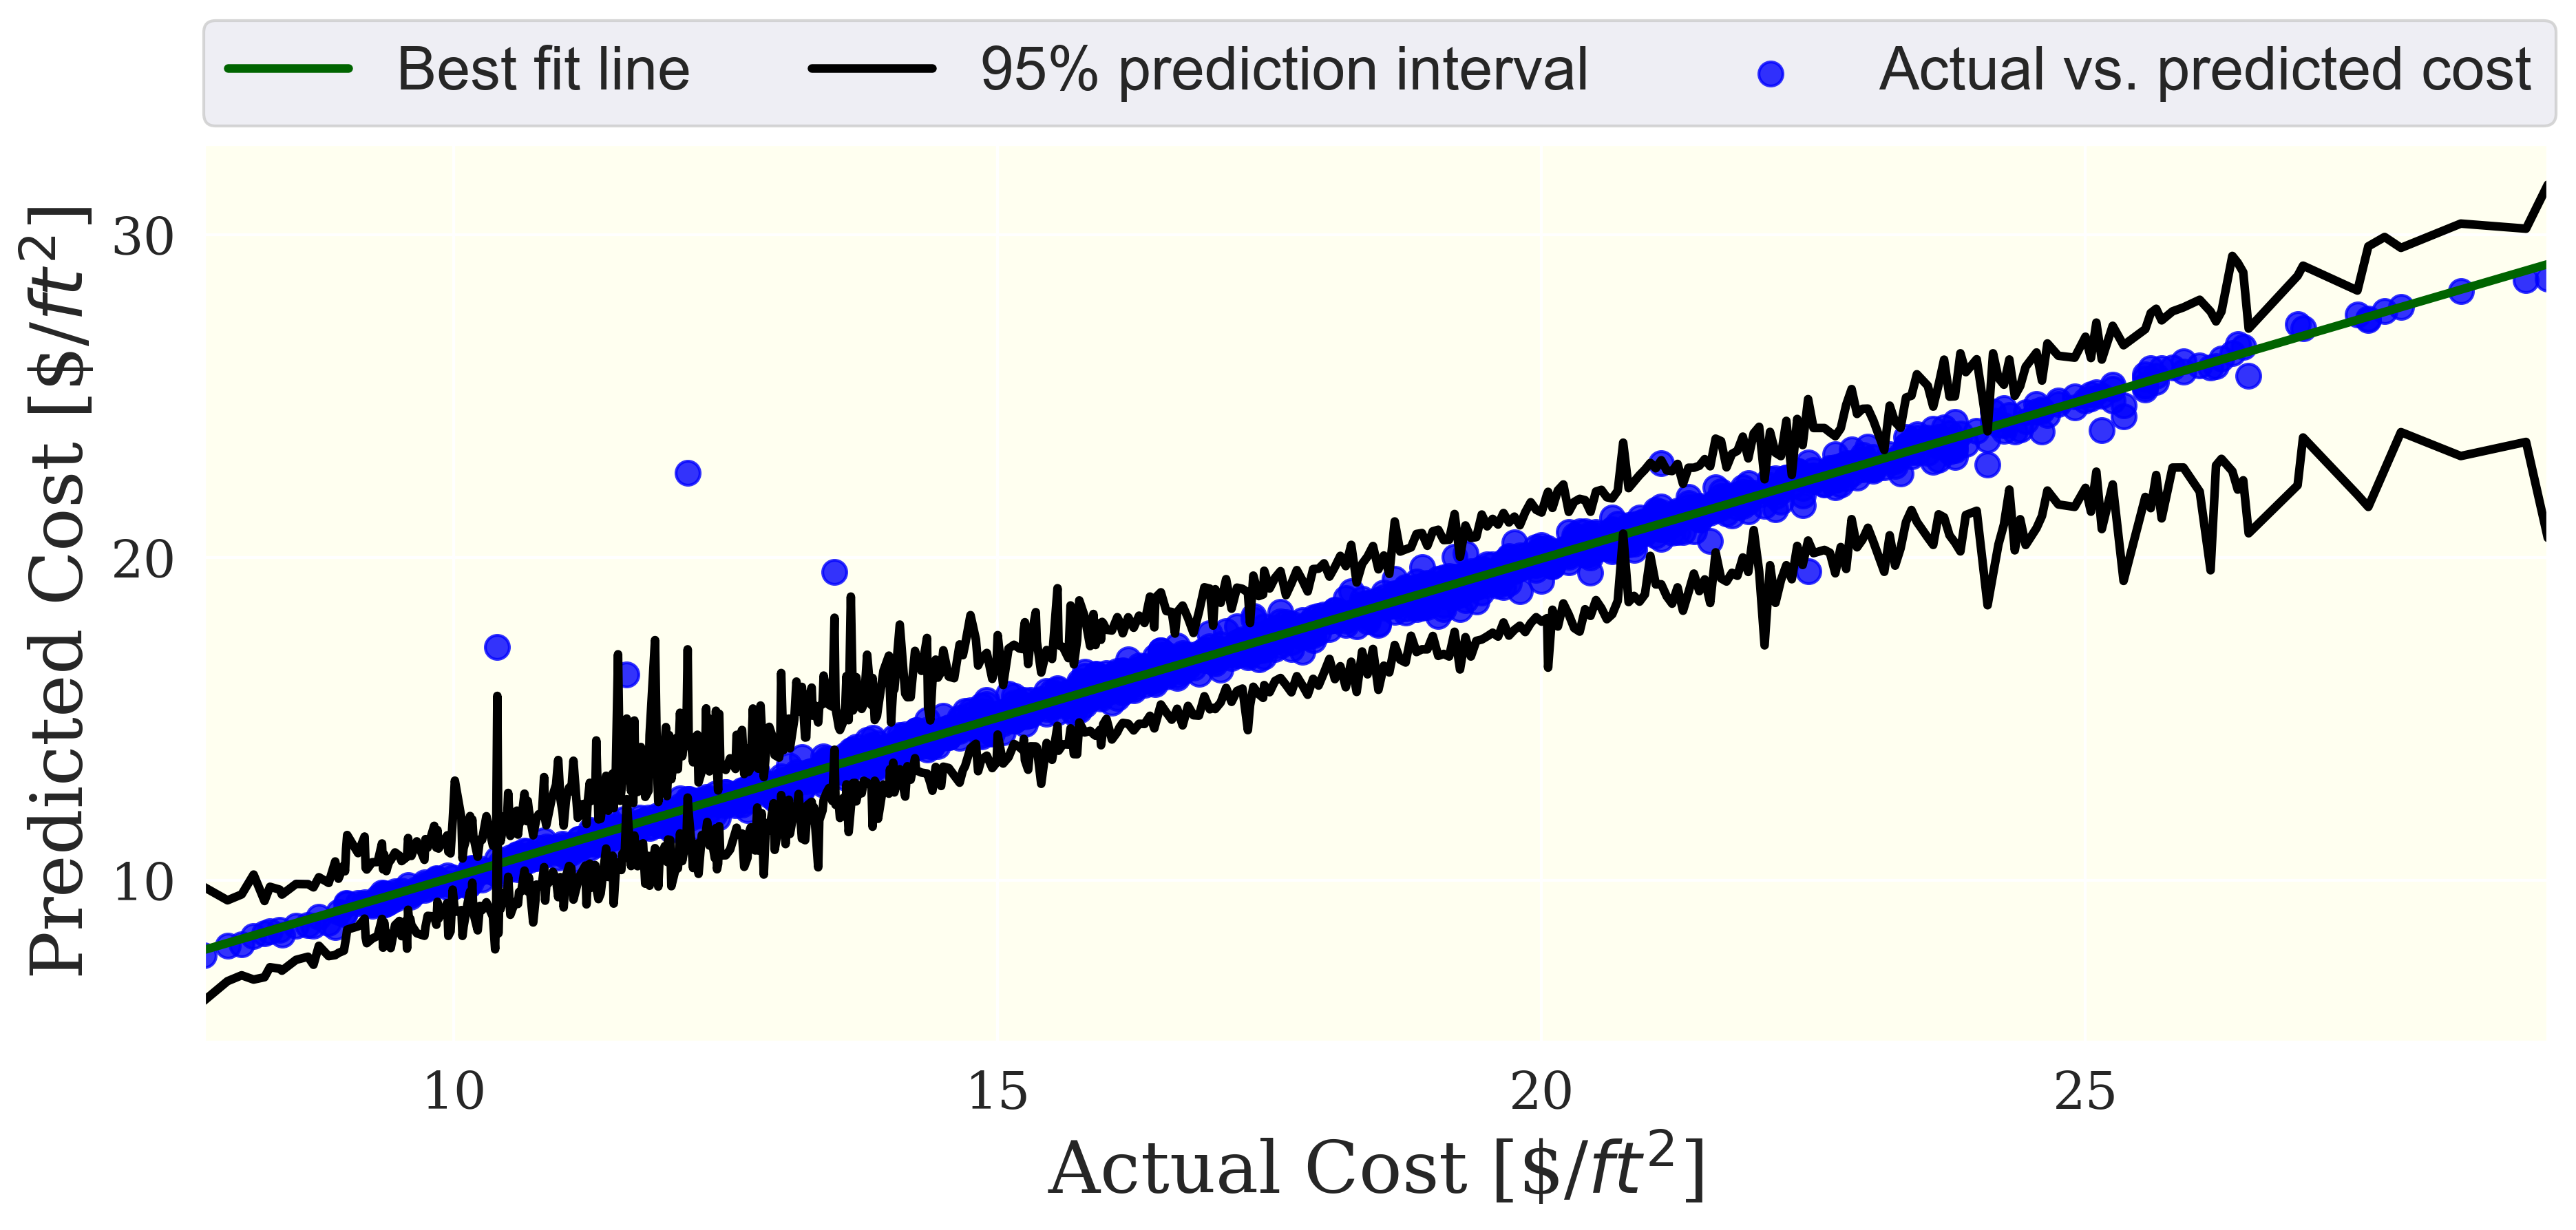

In [15]:
fig = plt.figure(figsize=(14,7),dpi=300)
ax = fig.add_subplot(1,1,1,facecolor='ivory')
sns.regplot(y_test, lgb.predict(X_test), x_ci='ci', label = 'Actual vs. predicted cost',
            scatter_kws={'color': 'blue', 's': 70},
            line_kws={'color': 'darkgreen', 'linewidth': 3, 'label': 'Best fit line'})

sns.lineplot(y_test, ngb_default.pred_dist(X_test).loc - 1.96 * ngb_default.pred_dist(X_test).scale, color = "black", 
             linestyle = "--", linewidth=3, ci =None)
sns.lineplot(y_test, ngb_default.pred_dist(X_test).loc + 1.96 * ngb_default.pred_dist(X_test).scale, color = "black", 
             linestyle = "--", linewidth=3, ci =None, label = '95% prediction interval')
plt.xlabel("Actual Cost [\$/$ft^2$]", fontsize=25, fontname='Serif')
plt.ylabel("Predicted Cost [\$/$ft^2$]", fontsize=25, fontname='Serif')
plt.xticks(fontsize=18, fontname='Serif')
plt.yticks(fontsize=18, fontname='Serif')
plt.figaspect(1.)
plt.legend(bbox_to_anchor=(0,1.02), loc="lower left", ncol=3, borderaxespad=0., prop={'size': 21})
plt.tight_layout(pad=1.08)
plt.savefig('Final Scatter Plot.pdf', format='pdf', dpi=300, bbox_inches = 'tight')

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


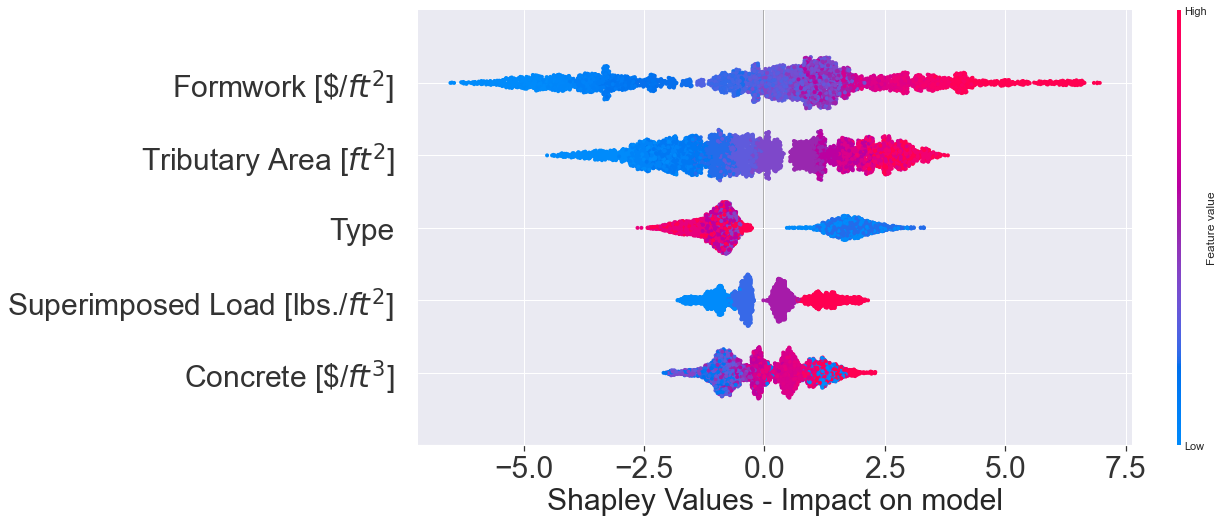

In [16]:
lgb_shap = LGBMRegressor(n_estimators=lgb.best_params_.get('n_estimators'),max_depth=lgb.best_params_.get('max_depth'),
                         learning_rate=lgb.best_params_.get('learning_rate'))

lgb_shap.fit(X, y.ravel())

explainer = shap.TreeExplainer(lgb_shap)
shap_values = explainer.shap_values(Data_DF[Feature_Names].to_numpy())

shap.summary_plot(shap_values, Data_DF[Feature_Names].to_numpy(), Feature_Names, plot_size=(16,8), show=False)
plt.xlabel('Shapley Values - Impact on model', fontsize=30)
plt.tick_params(labelsize=30)
plt.savefig('Feature Importance - SHAP.pdf', format='pdf', dpi=300, bbox_inches = 'tight')

In [17]:
shap.force_plot(explainer.expected_value, shap_values, Data_DF[Feature_Names].to_numpy())

shap.force_plot is slow for many thousands of rows, try subsampling your data.


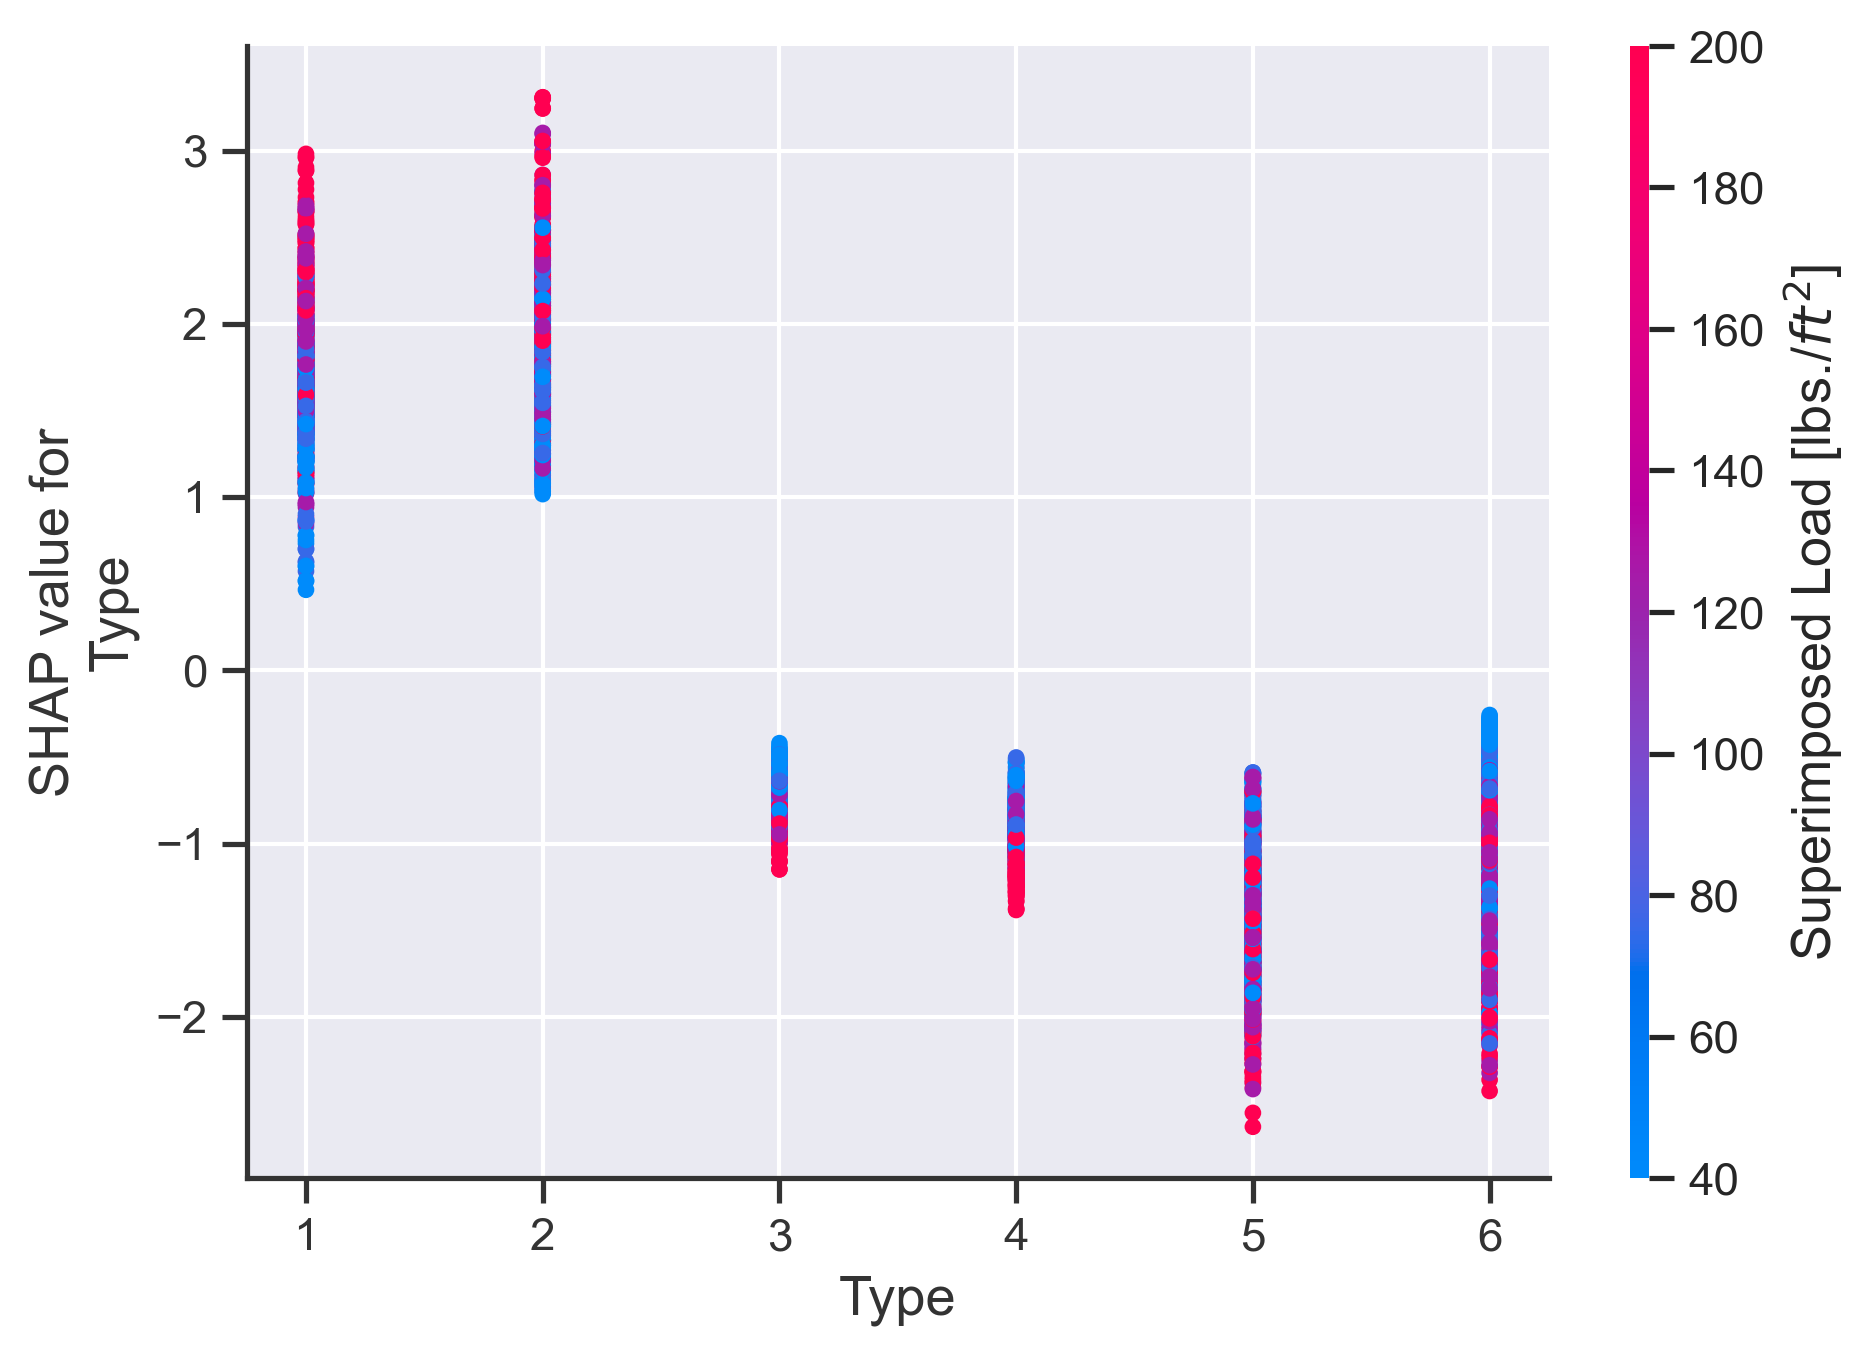

In [18]:
fig = plt.figure(figsize=(7,5),dpi=300)
ax1 = fig.add_subplot(1,1,1)

shap.dependence_plot('Type',shap_values, Data_DF[Feature_Names].to_numpy(),Feature_Names, ax=ax1, show=False)

plt.savefig('Feature Interaction - Type.pdf', format='pdf', dpi=300, bbox_inches = 'tight')

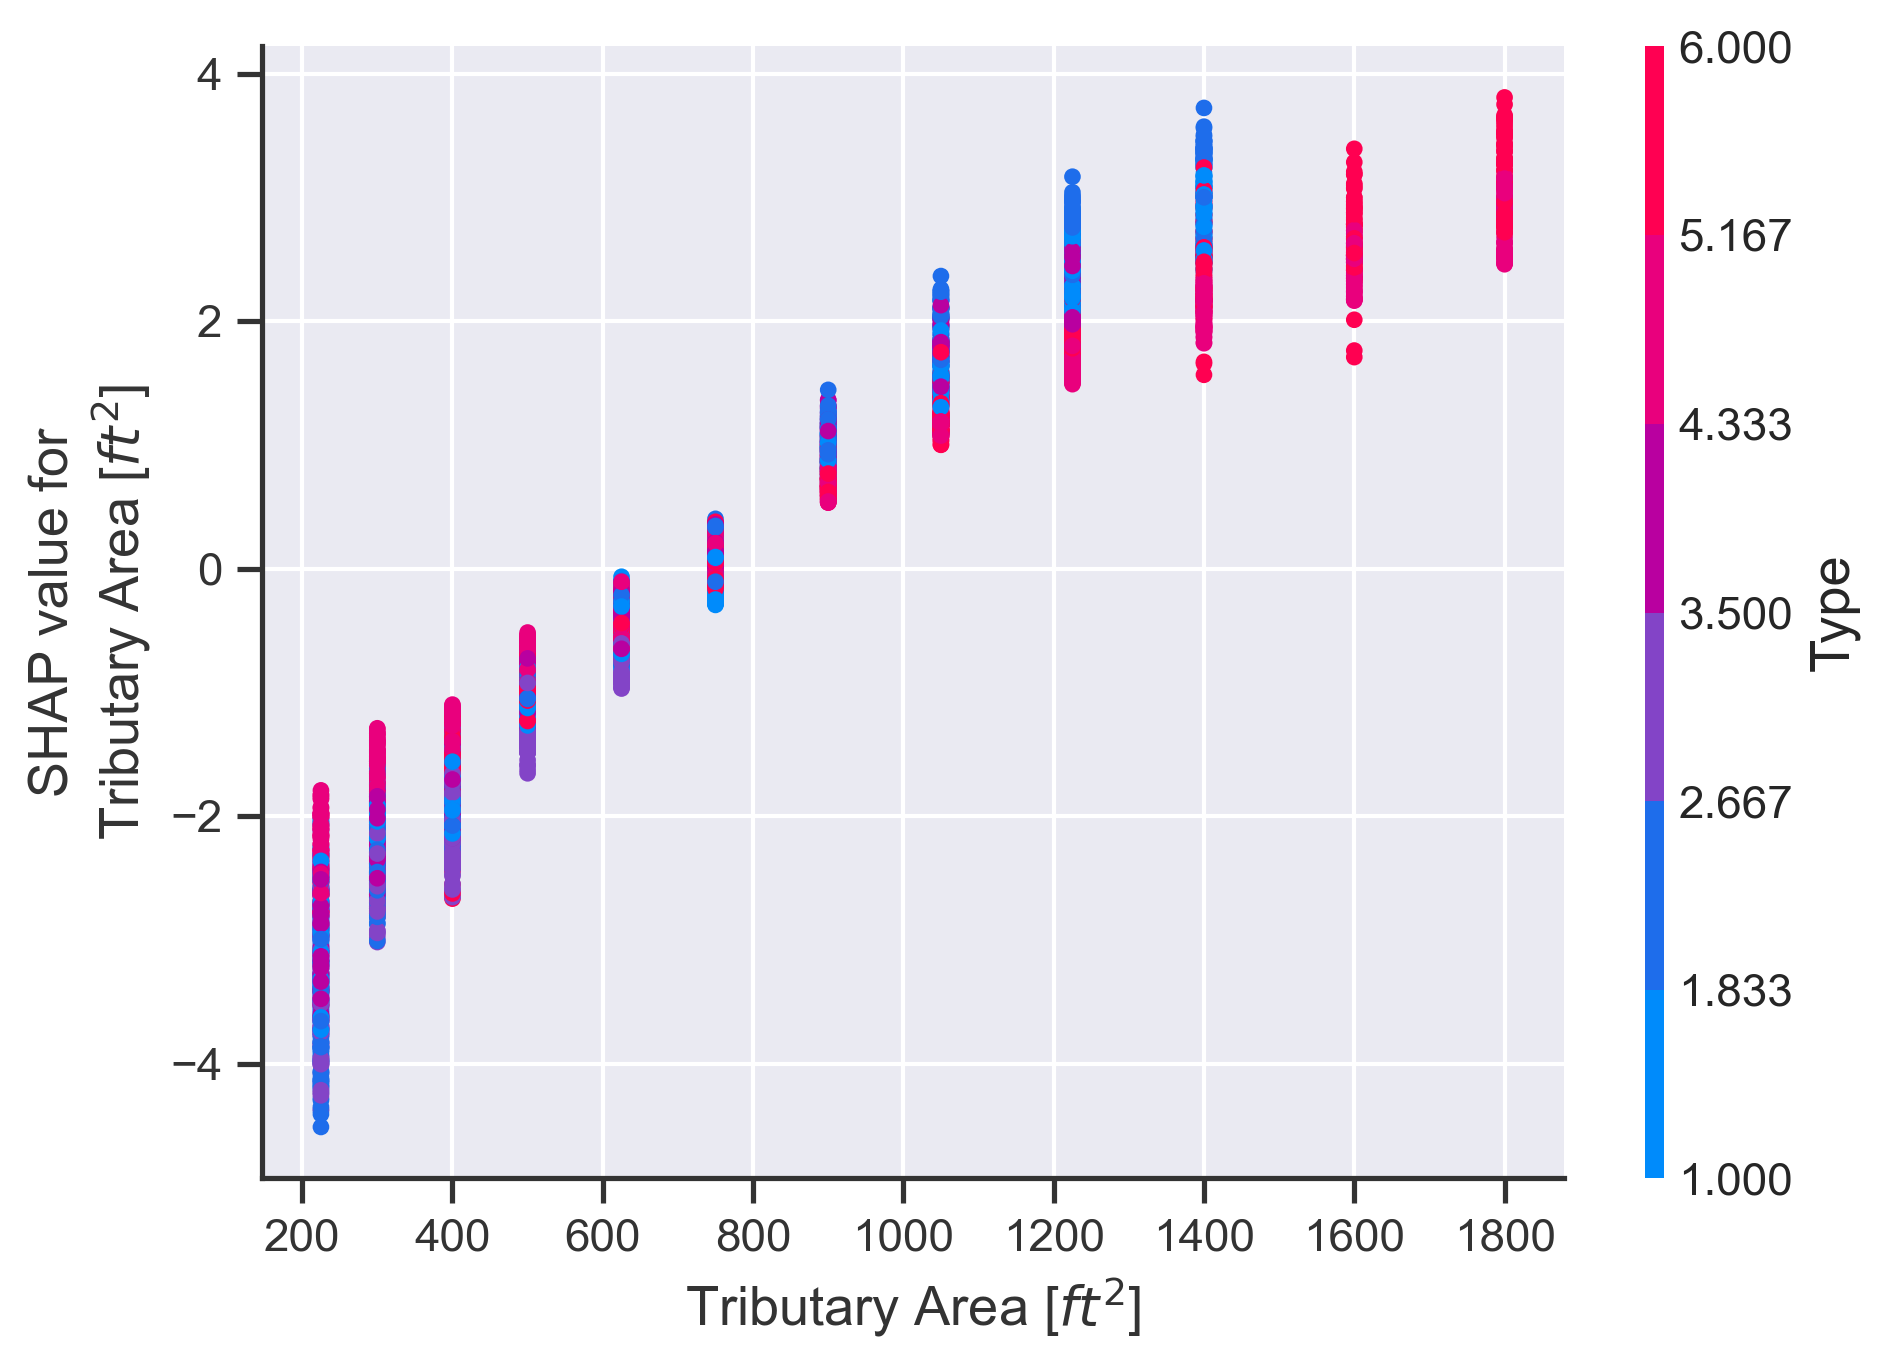

In [19]:
fig = plt.figure(figsize=(7,5),dpi=300)
ax1 = fig.add_subplot(1,1,1)

shap.dependence_plot('Tributary Area [$ft^2$]',shap_values, Data_DF[Feature_Names].to_numpy(),Feature_Names, ax=ax1, show=False)

plt.savefig('Feature Interaction - Area.pdf', format='pdf', dpi=300, bbox_inches = 'tight')

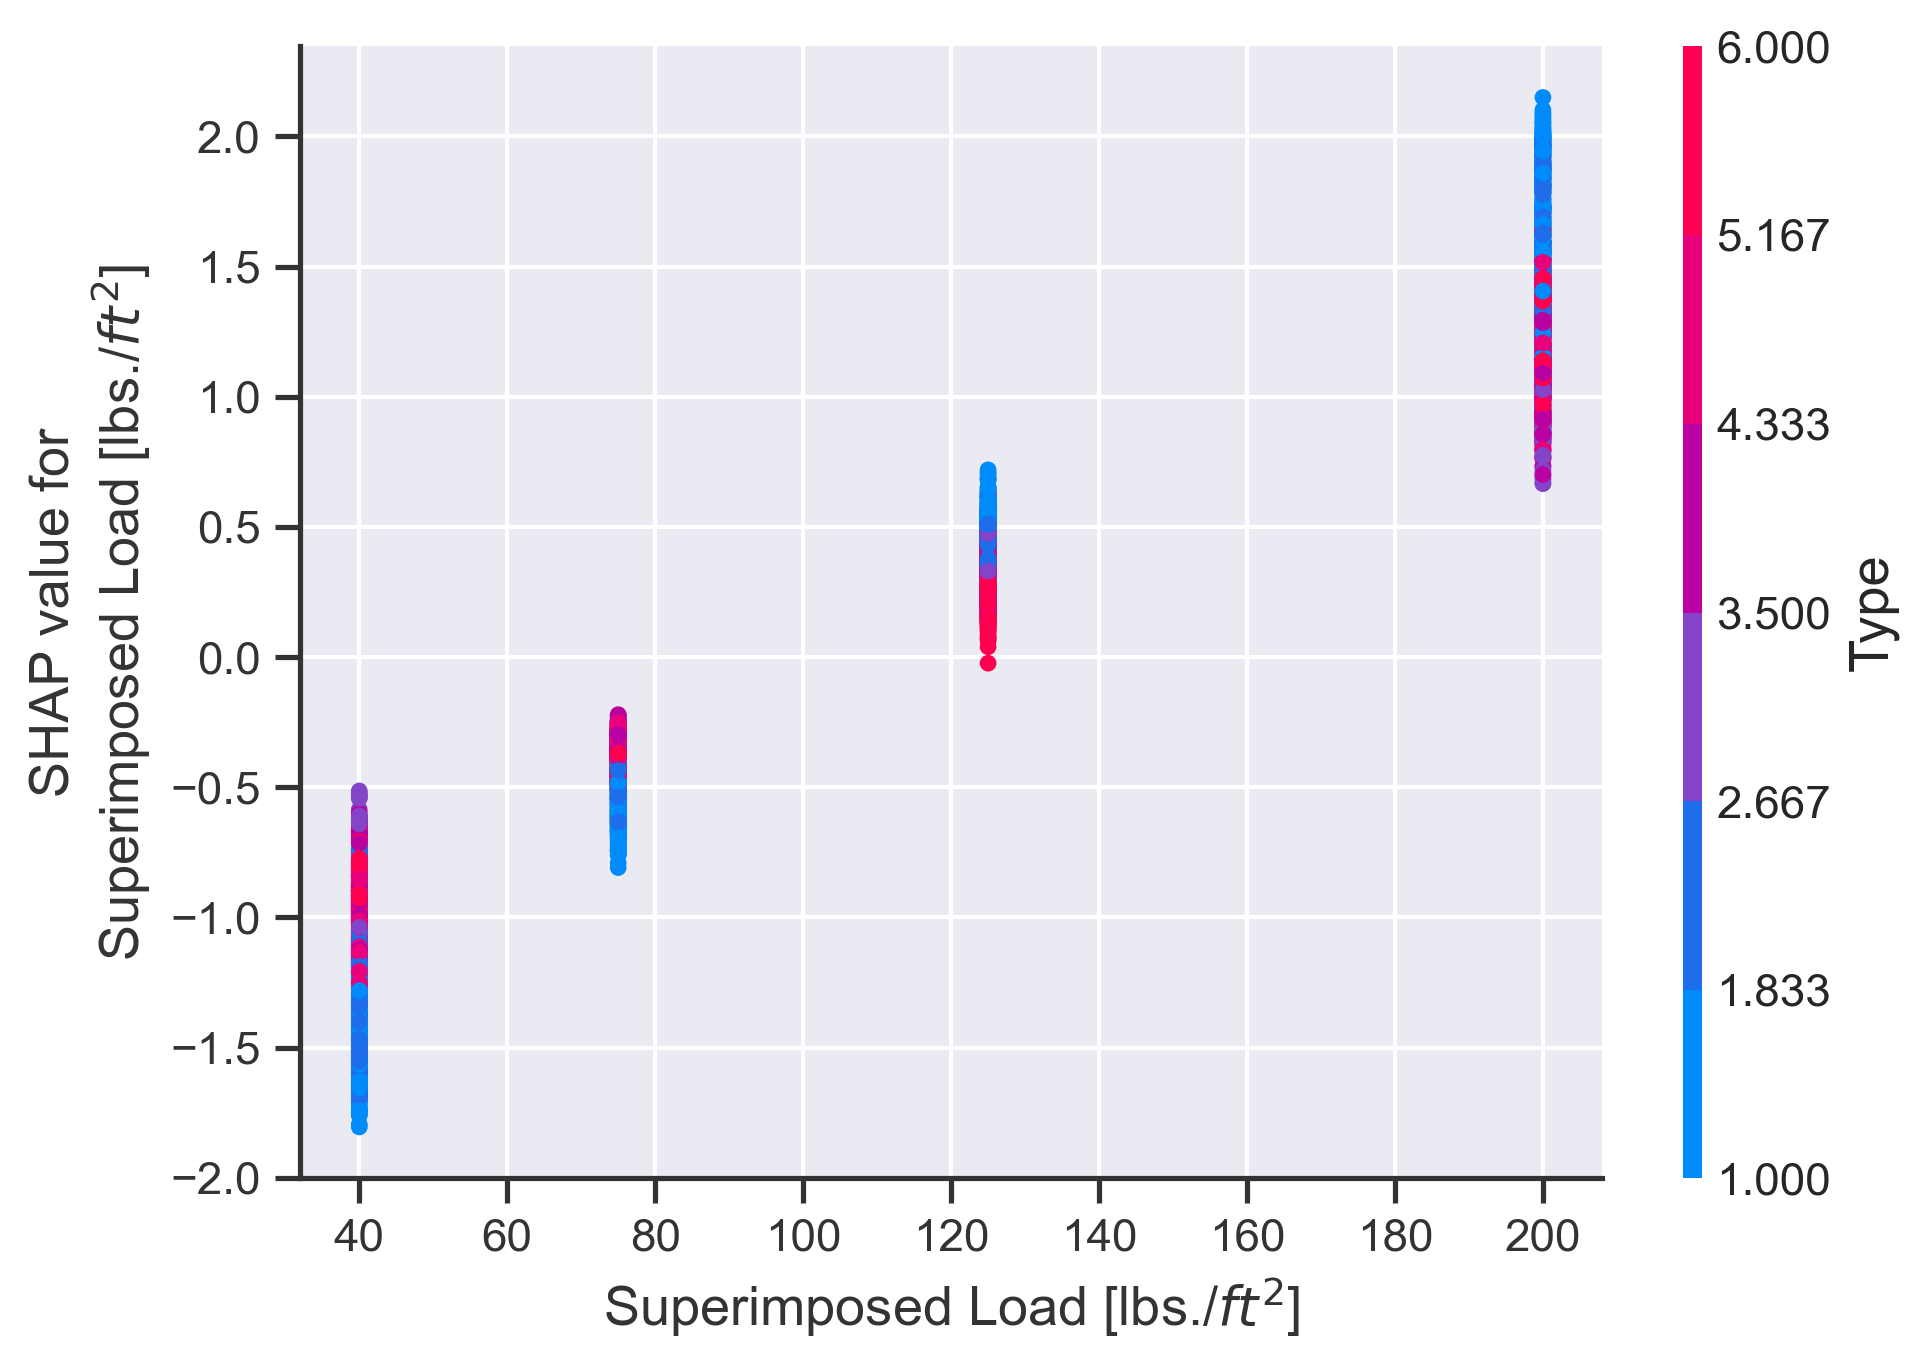

In [20]:
fig = plt.figure(figsize=(7,5),dpi=300)
ax1 = fig.add_subplot(1,1,1)

shap.dependence_plot('Superimposed Load [lbs./$ft^2$]',shap_values, Data_DF[Feature_Names].to_numpy(),Feature_Names, ax=ax1, show=False)

plt.savefig('Feature Interaction - Load.pdf', format='pdf', dpi=300, bbox_inches = 'tight')

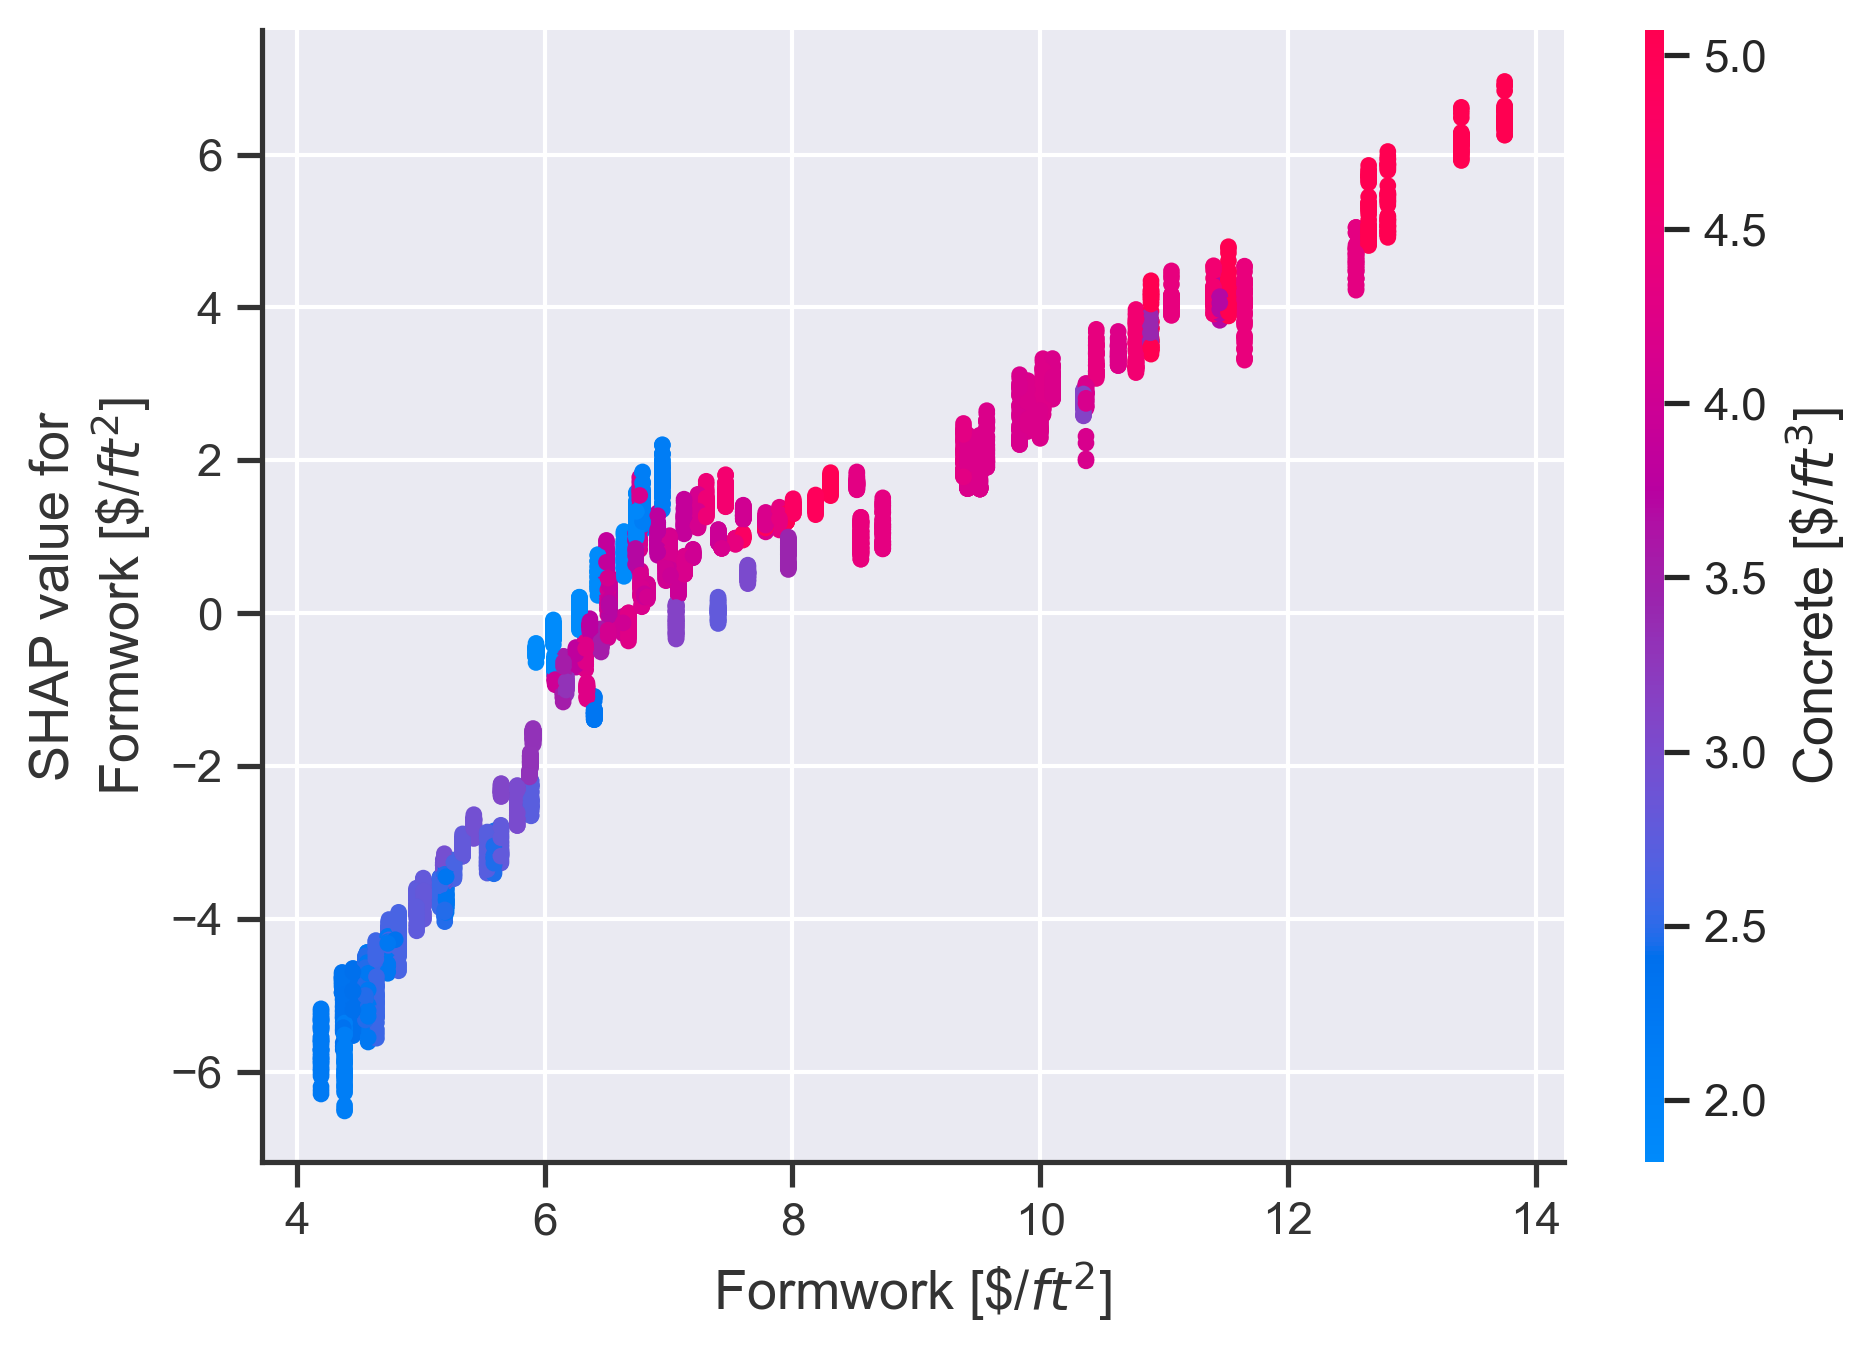

In [21]:
fig = plt.figure(figsize=(7,5),dpi=300)
ax1 = fig.add_subplot(1,1,1)

shap.dependence_plot('Formwork [\$/$ft^2$]',shap_values, Data_DF[Feature_Names].to_numpy(),Feature_Names, ax=ax1, show=False)

plt.savefig('Feature Interaction - Formwork.pdf', format='pdf', dpi=300, bbox_inches = 'tight')

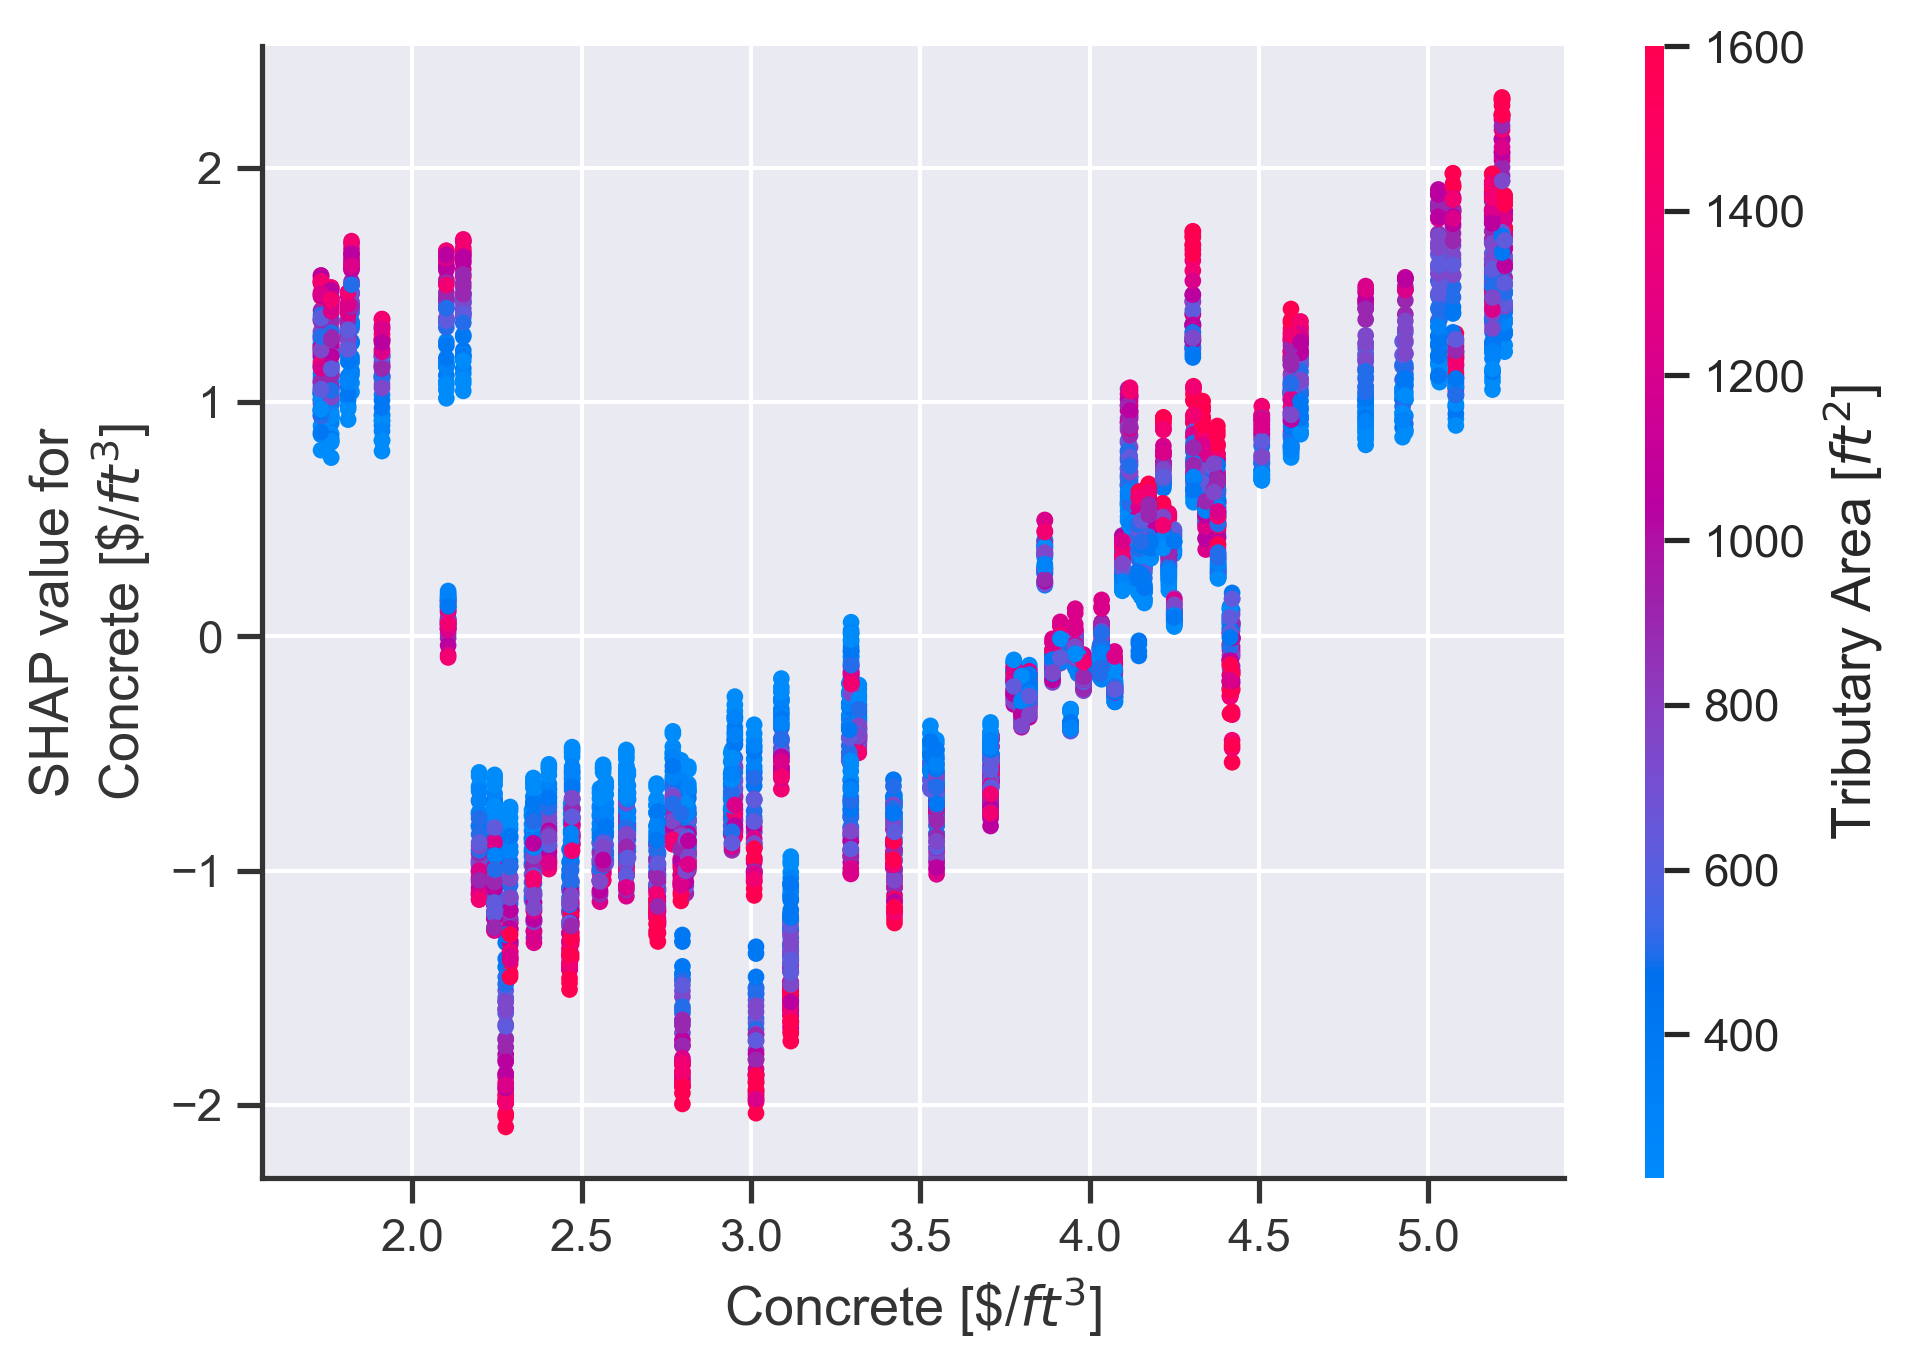

In [22]:
fig = plt.figure(figsize=(7,5),dpi=300)
ax1 = fig.add_subplot(1,1,1)

shap.dependence_plot('Concrete [\$/$ft^3$]',shap_values, Data_DF[Feature_Names].to_numpy(),Feature_Names, ax=ax1, show=False)

plt.savefig('Feature Interaction - Concrete.pdf', format='pdf', dpi=300, bbox_inches = 'tight')

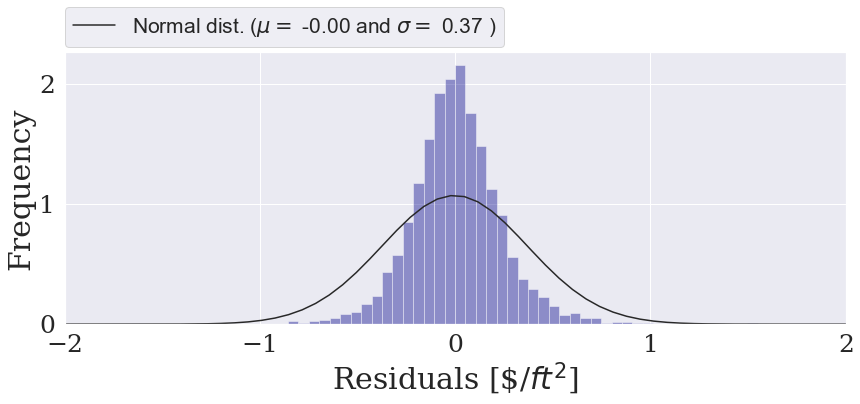

In [23]:
residuals = (np.concatenate((y_train.ravel(),y_test.ravel())) - np.concatenate((lgb.predict(X_train),lgb.predict(X_test))))
fig = plt.figure(figsize=(14,5))
sns.distplot(residuals, fit = norm, color='darkblue',kde=False,bins=250)
(mu, sigma) = norm.fit(residuals)
# plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best', fontsize=30)
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
           bbox_to_anchor=(0,1.02), loc="lower left", ncol=3, borderaxespad=0., prop={'size': 21})
plt.xlabel('Residuals [\$/$ft^2$]', fontsize=30, fontname='Serif')
plt.ylabel('Frequency', fontsize=30, fontname='Serif')
plt.xticks(fontsize=25, fontname='Serif')
plt.yticks(fontsize=25, fontname='Serif')
plt.xlim(-2, 2)
plt.figaspect(1.)
plt.title('')
plt.savefig('Residual Distribution.pdf', format='pdf', dpi=300, bbox_inches = 'tight')